<a href="https://colab.research.google.com/github/Patrick5455/Change-Point-Analysis-of-Covid19-Bayesian-Inference-SIR-SEIR-Modelling/blob/master/dependencies/covid19_inference-master/scripts/interactive/example_one_bundesland.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Change Point Analysis to Quantify the Impact of the Ghanian Government Policy Interventions to Slow the Spread of COVID-19

### The Analysis would be conducted using Bayesian Inference based on Markov chain Monte Carlo sampling to a class of compartmental models [susceptible-infected-recovered (SIR)]


-  Patrick Ojunde (Team Ghana)



---



>> For easier Navigation, open with Google-Colab Link above and use the Table of Contents in the left pane


`Mount Google Drive to save files and visuals`

In [1]:
 #To mount the Google Drive
from google.colab import drive
drive.mount('/content/gdrive')#To Save the trace results to a pickle file

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


`install the library to be used for this analysis`

check [here](https://science.sciencemag.org/content/sci/369/6500/eabb9789.full.pdf) for more info on the research work for this library

In [2]:
!pip install git+https://github.com/Priesemann-Group/covid19_inference.git

  Cloning https://github.com/Priesemann-Group/covid19_inference.git to /tmp/pip-req-build-lzy7_9ja
  Running command git clone -q https://github.com/Priesemann-Group/covid19_inference.git /tmp/pip-req-build-lzy7_9ja
  Created wheel for covid19-inference: filename=covid19_inference-0.1.8a0-cp36-none-any.whl size=103637 sha256=6e1b5d3725707b4ed7b7875ffe822f1462476a887090daa0904c8e0e85001c53
  Stored in directory: /tmp/pip-ephem-wheel-cache-svukleeq/wheels/da/f1/e7/da56ba4fe019b70927b4bb10088f02f672b31b69fd54a6e613
Successfully built covid19-inference




1.   List item
2.   List item



# Bayesian Inference of Ghana Covid 19 Data
Non-hierarchical model using jhu data.

Runtime ~ 15 min

The first thing we need to do is import some essential stuff. Theses have to be installed and are prerequisites.


In [3]:
import datetime
import time as time_module
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import theano
import theano.tensor as tt
import pymc3 as pm
import pickle

In [4]:
# Now to the fun stuff, we import our module!
try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../../")
    import covid19_inference as cov19

### Define Utility Functions

> These functions would be called at various intervals to make the notebook neater and easy to naviagte![alt text](https://)

Save Model


In [5]:
def save_load_model (action, model=None, model_name='new_model.pickle',
                          path = '/content/gdrive/My Drive/10Academy/projects/Ghana_SER_Model/models_and_traces/'):

  if action == "wb":
    pickle_out = open(path+model_name,action)
    pickle.dump(model, pickle_out)
    pickle_out.close() 

  elif action=="rb":
    pickle_in = open(path+model_name,action)
    model=pickle.load(pickle_in)
    
    return model

####save model trace


In [6]:
def save_load_modelTrace (action, modelTrace=None, modelTrace_name='new_model_trace.pickle',
                          path = '/content/gdrive/My Drive/10Academy/projects/Ghana_SER_Model/models_and_traces/'):

  if action == "wb":
    pickle_out = open(path+modelTrace_name,action)
    pickle.dump(modelTrace, pickle_out)
    pickle_out.close() 

  elif action=="rb":
    pickle_in = open(path+modelTrace_name,action)
    modelTrace=pickle.load(pickle_in)
    
    return modelTrace

#### Plot timeseries

In [7]:
def plot_timeseries(model, model_trace, start=None, end=None,
                    file_name="new_timeseries.png", offset=3000,
                    path = '/content/gdrive/My Drive/10Academy/projects/Ghana_SER_Model/visuals/',
                    add_more_later=False
                    ):
  
  if start and end:
    fig, axes = cov19.plot.timeseries_overview(model, model_trace,annotate_watermark=True,
                                             
                                             save_to=path+file_name, forecast_label='Ghana Forecast',

                                             forecast_heading="Ghana Covid19 Forecast",

                                             add_more_later=add_more_later,
                                             
                                     offset=offset, start=datetime.datetime(start), end=datetime.datetime(end))
    
  else:
      fig, axes = cov19.plot.timeseries_overview(model, model_trace,annotate_watermark=True,
                                             
                                             save_to=path+file_name, forecast_label='Ghana Forecast',

                                             forecast_heading="Ghana Covid19 Forecast",

                                             add_more_later=add_more_later,
                                             
                                     offset=offset)
  #plt.savefig(fname=path+file_name, format='png')

  #return fig

#### Plot simple timeseries

In [8]:
def plot_simpleTimeSeries(data,type_of_plot = 'data', save_as ='new_simple_timeseries.png'):

  path = '/content/gdrive/My Drive/10Academy/projects/Ghana_SER_Model/visuals/'

  """
   low-level function to plot anything that has a date on the x-axis.

        Parameters
        ----------
        x : array of datetime.datetime
            times for the x axis

        y : array, 1d or 2d
            data to plot. if 2d, we plot the CI as fill_between (if CI enabled in rc
            params)
            if 2d, then first dim is realization and second dim is time matching `x`
            if 1d then first tim is time matching `x`

         what: str, optional
            what type of data is provided in x. sets the style used for plotting:
            * `data` for data points
            * `fcast` for model forecast (prediction)
            * `model` for model reproduction of data (past)

    """

  date=data.index
  figures=data
  fig = cov19.plot._timeseries(x=date, y=figures, what=type_of_plot)
  plt.savefig(fname=path+save_as, format='png')
  return fig

#### Plot Posterior Parameters

In [9]:
def plot_distributions(model_trace, model, color=None, 
                       save_as='new_distro.png', 
                       path = '/content/gdrive/My Drive/10Academy/projects/Ghana_SER_Model/visuals/'):
  
    fig, axes = plt.subplots(6, 3, figsize=(10, 8))
    left_column = []
    mid_column = []
    right_column = []
    #axes[0, 2].set_visible(False)
    #axes[1, 2].set_visible(False)
    #this_model.name

    left_vars = ["weekend_factor", "mu", "lambda_0", "lambda_1", "lambda_2", "lambda_3"]

    mid_vars = ["offset_modulation","sigma_obs","I_begin","transient_day_1","transient_day_2","transient_day_3"]

    right_vars =  ["delay", "transient_len_1", "transient_len_2", "transient_len_3"]



    # I have to comment out the codes because I could not plot distributions for a model that I specified its name...

    # the covid19_inference/plot.py needs to be refactored to accomidate this

    # I opened an issue for this on github

    # Error log below

    """

      KeyError                                  Traceback (most recent call last)

      <ipython-input-309-983232f0c631> in <module>()
      ----> 1 plot_distributions(model=this_model,model_trace=model1, color='b')

      2 frames

      <ipython-input-308-056ce75e6fe4> in plot_distributions(model_trace, model, color)
          33 
          34     for idx, var in enumerate(left_column):
      ---> 35         cov19.plot._distribution(model, model_trace, var, ax=axes[idx, 0], color=color)
          36 
          37     for idx, var in enumerate(mid_column):

      /usr/local/lib/python3.6/dist-packages/covid19_inference/plot.py in _distribution(model, trace, key, ax, color, draw_prior)
          767     if "lambda" in key or "mu" == key:
          768         ax.set_xlim(0, 0.5)
      --> 769         ax.axvline(np.median(trace["mu"]), ls=":", color="black")
          770     elif "I_begin" == key:
          771         ax.set_xlim(0)

      /usr/local/lib/python3.6/dist-packages/pymc3/backends/base.py in __getitem__(self, idx)
          317         if var in self.stat_names:
          318             return self.get_sampler_stats(var, burn=burn, thin=thin)
      --> 319         raise KeyError("Unknown variable %s" % var)
          320 
          321     _attrs = set(['_straces', 'varnames', 'chains', 'stat_names',

      KeyError: 'Unknown variable mu'


      """


          # for var in left_vars:
          #   left_column.append(model.name+f"_{var}")
          # print(left_column)

          # for var in mid_vars:
          #   mid_column.append(model.name+f"_{var}")

          # print(mid_column)

          # for var in right_vars:
          #   right_column.append(model.name+f"_{var}")
            
          # print(right_column)

    


    for idx, var in enumerate(left_vars):
      cov19.plot._distribution(model, model_trace, var, ax=axes[idx, 0], color=color)

    for idx, var in enumerate(mid_vars):
        cov19.plot._distribution(model, model_trace, var, ax=axes[idx, 1], color=color)

    for idx, var in enumerate(right_vars):
        cov19.plot._distribution(model, model_trace, var, ax=axes[idx+2, 2], color=color)

    fig.tight_layout()
    plt.savefig(fname=path+save_as, format='png')
    return fig

#### Create Model

In [10]:
 def create_model(model_params, change_points, data_end=None, sim_begin=None, sim_end=None, pr_delay=3):
   with cov19.model.Cov19Model(**model_params) as this_model:

      """
      params_model is used to initlaise an object instance of Cov19Model

          change_points is a list of dates used to specify the change points for our model

          model_type could be SIR or SIER

          pr_delay = Median of the prior for the delay in case reporting, we assume 3 days
      """



    #specify extra attriubutes
      if data_end:
        data_end=data_end
      if sim_begin:
        sim_begin=sim_begin
      if sim_end:
        sim_end=sim_end      

     
      # Create the an array of the time dependent infection rate lambda
      lambda_t_log = cov19.model.lambda_t_with_sigmoids(
          pr_median_lambda_0=0.4,
          pr_sigma_lambda_0=0.5,
          change_points_list=change_points,  # The change point priors we constructed earlier
          name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
      )

      # set prior distribution for the recovery rate
      mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

      # This builds a decorrelated prior for I_begin for faster inference.
      # It is not necessary to use it, one can simply remove it and use the default argument
      # for pr_I_begin in cov19.SIR
      prior_I = cov19.model.uncorrelated_prior_I(
          lambda_t_log=lambda_t_log,
          mu=mu,
          pr_median_delay=pr_delay,
          name_I_begin="I_begin",
          name_I_begin_ratio_log="I_begin_ratio_log",
          pr_sigma_I_begin=2,
          n_data_points_used=5,
      )

      # Use lambda_t_log and mu to run the SIR model
      new_cases = cov19.model.SIR(
          lambda_t_log=lambda_t_log,
          mu=mu,
          name_new_I_t="new_I_t",
          name_I_t="I_t",
          name_I_begin="I_begin",
          pr_I_begin=prior_I,
      )

      # Delay the cases by a lognormal reporting delay
      new_cases = cov19.model.delay_cases(
          cases=new_cases,
          name_cases="delayed_cases",
          name_delay="delay",
          name_width="delay-width",
          pr_mean_of_median=pr_delay,
          pr_sigma_of_median=0.2,
          pr_median_of_width=0.3,
      )

      # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
      # Also adds the "new_cases" variable to the trace that has all model features.
      new_cases = cov19.model.week_modulation(
          cases=new_cases,
          name_cases="new_cases",
          name_weekend_factor="weekend_factor",
          name_offset_modulation="offset_modulation",
          week_modulation_type="abs_sine",
          pr_mean_weekend_factor=0.3,
          pr_sigma_weekend_factor=0.5,
          weekend_days=(6, 7),
      )

      # Define the likelihood, uses the new_cases_obs set as model parameter
      cov19.model.student_t_likelihood(new_cases)
      return this_model


## Data retrieval 

> Task a -c

- Download the COVID19 case data for your assigned country

- Pre-process the downloaded data such that the starting date of the data is when the number of covid19 cases in your country reaches 100 and dominated by a community transmission.

- It is unlikely but, if there are dates that have NaN values, perform linear regression to fill these missing values. Make sure the final data has a continuous date - ensure no date is missing. Zero number of cases for a given date is ok.



> Use John Hopkins Database

In [11]:
jhu = cov19.data_retrieval.JHU()  # It is important to download the dataset!
jhu.download_all_available_data()
# One could also parse True to the constructor of the class to force an auto download

INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local


### Get total confirmed case for Ghana and its new cases
> Ghana recorded its first covid case on 14th of March


In [12]:
bd = datetime.datetime(2020, 3, 14)  # first covid case
ed = datetime.datetime.now() # data ends today

In [13]:
total_cases_obs = jhu.get_total(
    value="confirmed", country="Ghana", data_begin=bd, data_end=ed
)
new_cases_obs = jhu.get_new(
    value="confirmed", country="Ghana", data_begin=bd, data_end=ed
)

In [14]:
total_cases_obs

date
2020-03-14        3
2020-03-15        6
2020-03-16        6
2020-03-17        7
2020-03-18        7
              ...  
2020-08-06    39642
2020-08-07    40097
2020-08-08    40533
2020-08-09    41003
2020-08-10    41212
Name: confirmed, Length: 150, dtype: int64

INFO     [numexpr.utils] NumExpr defaulting to 2 threads.


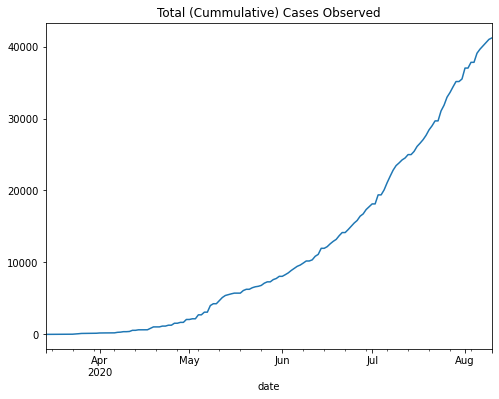

In [15]:
total_cases_obs.plot(figsize=(8,6))
plt.title('Total (Cummulative) Cases Observed')
plt.savefig(fname='/content/gdrive/My Drive/10Academy/projects/Ghana_SER_Model/visuals/totalCases_cumm.png', format='png')

In [16]:
new_cases_obs

date
2020-03-14      3
2020-03-15      3
2020-03-16      0
2020-03-17      1
2020-03-18      0
             ... 
2020-08-06    567
2020-08-07    455
2020-08-08    436
2020-08-09    470
2020-08-10    209
Name: confirmed, Length: 150, dtype: int64

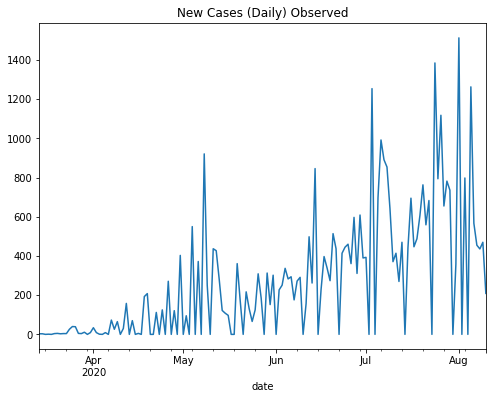

In [17]:
new_cases_obs.plot(figsize=(8,6))
plt.title('New Cases (Daily) Observed')
plt.savefig(fname='//content/gdrive/My Drive/10Academy/projects/Ghana_SER_Model/visuals/newCases_daily.png', format='png')

# Preprocessing and Modelling 
> Task d - j
- Split the data into one part used for inference (training set), and an other used for to validate a forecast (validation set):
- - Training set includes all dates from the time the community transmission reaches 100 to July 25 2020.
- - Validation set includes dates from 25 July 2020 to one final date in the covid19 cases data.  
- Plot the training data together with the model that is sampled from the posterior of the SIR model. The posterior of the SIR model means distributions on the Lambda, Mu, and other parameters. A single model curve means a single sample from the posterior distribution.
- Use the validation data set to evaluate the forecasting power of the model you generated using the training set. If you are happy with your model, you can run it to make predictions until the 10th of August.
- Find the dates where your country introduced the following policies. You can find the policies different countries introduced in the Oxford COVID tracker & IMF policy tracker. 
- - Banning major gatherings 
- - School closures
- - Required social distancing
- - Mask wearing mandatory
- - Relaxing the previous rules
- -Find those policies that are announced after the number of cases reach 100. - - Make sure you have at least one policy that falls in your data date range.   
- - Introduce the dates of the policies you found in step (g) as change points in your model with prior centered at the times the country introduced these policies. 
 __In the example paper, Germany had three specific points which were mild social distancing, strong social distancing and contact ban on 2020-3-9, 2020-3-16, and 2020-3-23.__

-  You are expected to get the following results after performing the parameter estimation and model comparison steps
- - Posterior distribution of SEIR model parameters 
- - The number of change points required in the model to best fit the data



In [18]:

train_set = new_cases_obs[new_cases_obs.index <= '2020-07-25']
val_set = total_cases_obs[total_cases_obs.index >= '2020-07-25']

In [19]:
print("Date Has empty row: ",f'{train_set.index.isnull().any()}')
train_set

Date Has empty row:  False


date
2020-03-14       3
2020-03-15       3
2020-03-16       0
2020-03-17       1
2020-03-18       0
              ... 
2020-07-21     559
2020-07-22     683
2020-07-23       0
2020-07-24    1385
2020-07-25     794
Name: confirmed, Length: 134, dtype: int64

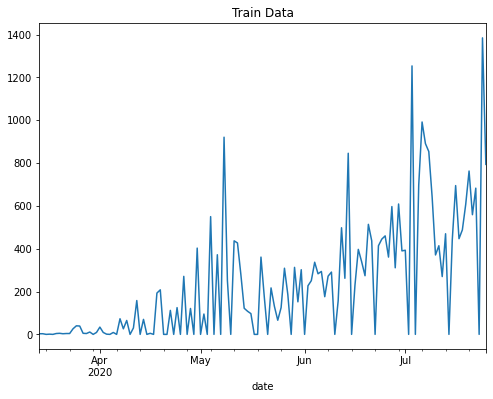

In [20]:

train_set.plot(figsize=(8,6))
plt.title('Train Data')
plt.savefig(fname='/content/gdrive/My Drive/10Academy/projects/Ghana_SER_Model/visuals/train_data_daily.png', format='png')

In [21]:
print("Date Has empty row: ",f'{val_set.index.isnull().any()}')
val_set

Date Has empty row:  False


date
2020-07-25    31851
2020-07-26    32969
2020-07-27    33624
2020-07-28    34406
2020-07-29    35142
2020-07-30    35142
2020-07-31    35501
2020-08-01    37014
2020-08-02    37014
2020-08-03    37812
2020-08-04    37812
2020-08-05    39075
2020-08-06    39642
2020-08-07    40097
2020-08-08    40533
2020-08-09    41003
2020-08-10    41212
Name: confirmed, dtype: int64

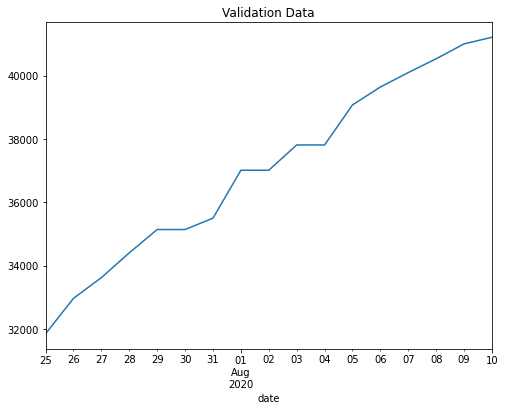

In [22]:
val_set.plot(figsize=(8,6))
plt.title('Validation Data')
plt.savefig(fname='/content/gdrive/My Drive/10Academy/projects/Ghana_SER_Model/visuals/val_data_cumm.png', format='png')

## Model training and Plotting 

> __before identifying changepoints from the model outputs__

#### Prior parameters

- pr_delay = 3

- population = 31072940

<!-- > I will compare my model output with validation set to see if there was significant change in the number of cases when the partial lockdown was introduced  -->
<!-- 
`I used these dates as prior becuase I believe there should be significant changepoints arounf these policy dates. But I will test my priors with the posteriors of my model. Note these dates are two days ahead the original dates to accomodate for the delay in effects of changepoints`  -->

<!-- > 1. 2020, 3, 30 - partial lockdown
2. 2020, 06,  15- ban on major gatherings
3. 2020, 07, 26 - restriction on travel -->

1. diff_data_sim - simulation of data should start ten days earlier before the start date of data

2. num_days_forcast - number of days to forecast after the end date of data

In [23]:
diff_data_sim = 10  # should be significantly larger than the expected delay, in order to always fit the same number of data points.
num_days_forecast = 3 #days

### Model 1 

> __1 Changepoint__


- Changepoints 

 `I will start with  just one changepoint here -date when government initiated a partial lockdown policy` 

 `Subsequent models would be built on more than one changepoint`  




March 30th

- March 30th : Partial Lockdown

> I used this date as prior becuase I believe there should be significant changepoint arounf this policy date. But I will test my prior with the posteriors of my model.


In [24]:
prior_date_mild_dist_begin = datetime.datetime(2020, 3, 30)
#prior_date_strong_dist_begin = datetime.datetime(2020, 6, 15)
#prior_date_contact_ban_begin = datetime.datetime(2020, 7, 26)

In [25]:
model1_change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1
    )
    # ),
    # dict(
    #     pr_mean_date_transient=prior_date_strong_dist_begin,
    #     pr_sigma_date_transient=1.5,
    #     pr_median_lambda=1 / 8,
    #     pr_sigma_lambda=1,
    # ),
    # dict(
    #     pr_mean_date_transient=prior_date_contact_ban_begin,
    #     pr_sigma_date_transient=1.5,
    #     pr_median_lambda=1 / 8 / 2,
    #     pr_sigma_lambda=1,
    # ),
]



Next, we create the model! There are default values for most of the function arguments,
but we will try to explicitly set all kwargs for the sake of this example.

`This would be used for all models`

In [26]:
params_model = dict(
    new_cases_obs=new_cases_obs,
    data_begin=bd,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=31072940,
    #name='Model1_SER',
)



The model is specified in a context. Each function in this context
has access to the model parameters set.


In [27]:
model1 = create_model(params_model, #sim_end=datetime.datetime(2020,8,4), sim_begin=datetime.datetime(2020,3,4), 
             change_points=model1_change_points)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


save model1


In [ ]:
#save model
save_load_model("wb", model1, "model1.pickle")
#load model
model1 = save_load_model("rb", model_name="model1.pickle")


## MCMC sampling

After the model is built, it is sampled using an MCMC sampler.
The number of parallel runs can be set with the argument `cores=`.
In particular, due to a bug in Theano, Windows users should set `cores=1`.
The sampling can take a long time.


In [ ]:
model1_trace =  pm.sample(model=model1, cores=4, tune=50, draws=100, init="advi+adapt_diag")


Save Model1 Trace Object

In [ ]:
#save model1_trace
save_load_modelTrace("wb", model1_trace, modelTrace_name="model1_trace.pickle")
#load model1_trace
model1_trace=save_load_modelTrace("rb", modelTrace_name="model1_trace.pickle")

In [ ]:
print(model1_trace.chains, "\n")
for i in model1_trace.varnames:
  print(i)
print(model1.name+"_weekend_factor")
# model1_trace.get_sampler_stats('mu')

### Plot Timeseries for model1 (one changepoint) and compare performance with validation set

In [ ]:
plot_timeseries(model1, model1_trace, file_name="model1_timeseries.png") 

Plot TImeseries for Validation data to compare

In [ ]:
#plot cummulative figures and forecaset for august 2
plot_simpleTimeSeries(data=val_set, save_as='valset.png', type_of_plot='fcast');

In [ ]:
new_cases_obs

In [ ]:
#plot daily new cases for August 2
plot_simpleTimeSeries(data=new_cases_obs.loc["2020-08-02":], save_as='valset.png', type_of_plot='fcast');

> From the above, our model performance can be better improved.

> The model does not seem to fit well in the daily number of reportted cases, 

> Its forecasting power is moderately strong and accurate, while the validation set shows over 36k reported case, the model for the train data predicts higher than 30k. 

> `The model can be improved by increasing its draw and tune size and number of chanegpoints`

### Model 2

__2 Changepoints__

March 30th and June 15

- March 30th : Partial Lockdown

- June 15 : COmpulsory use of Facemasks

> I used these dates as prior becuase I believe there should be significant changepoint around these policy dates. But I will test my prior with the posteriors of my model.

> Indented block




In [ ]:
prior_date_mild_dist_begin = datetime.datetime(2020, 3, 30)
prior_date_strong_dist_begin = datetime.datetime(2020, 6, 15)
#prior_date_contact_ban_begin = datetime.datetime(2020, 7, 26)

In [ ]:
model2_change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1
    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=1,
    )
    # dict(
    #     pr_mean_date_transient=prior_date_contact_ban_begin,
    #     pr_sigma_date_transient=1.5,
    #     pr_median_lambda=1 / 8 / 2,
    #     pr_sigma_lambda=1,
    # )
]

In [ ]:
model2 = create_model(params_model, #sim_end=datetime.datetime(2020,8,4), sim_begin=datetime.datetime(2020,3,4), 
             change_points=model2_change_points)

*save and load* model2


In [ ]:
#save model 2
save_load_model("wb", model2, "model2.pickle")
#load model 2
model2 = save_load_model("rb", model_name="model2.pickle")


## MCMC sampling

After the model is built, it is sampled using an MCMC sampler.
The number of parallel runs can be set with the argument `cores=`.
In particular, due to a bug in Theano, Windows users should set `cores=1`.
The sampling can take a long time.


In [ ]:
model2_trace =  pm.sample(model=model2, cores=8, tune=100, draws=250, init="advi+adapt_diag")

Save Model2 Trace Object

In [ ]:
#save model2_trace
save_load_modelTrace("wb", model2_trace, modelTrace_name="model2_trace.pickle")
#load model2_trace
model2_trace=save_load_modelTrace("rb", modelTrace_name="model2_trace.pickle")

In [ ]:
print(model2_trace.chains, "\n")
for i in model2_trace.varnames:
  print(i)

### Plot Timeseries for model2 (Two changepoints) and compare performance with validation set

In [ ]:
plot_timeseries(model2, model2_trace, file_name="model2_timeseries.png")

Plot TImeseries for Validation data to compare

In [ ]:
plot_simpleTimeSeries(data=val_set, save_as='valset.png', type_of_plot='fcast');

### Model 2 Performance 

> The model's perfromance is quite similiar to that of model 1 but with better prediction,

> We can also observe that there was no significant decrease in the number of case (changepoint) from the last government policy on June 15. It remains an upward trend

> However, we were able to detec a steady decrease in COVID-19 growth rate (Lambda) in March when the partial lockdown policy was iniitaited also there has been a steady decline in spread rate tendimg towards exponential decay (around June the period when the second policy was initiated - compulsory use of facemasks) as the growth rate tends below the support line.

> We would test our model further with more changepoints and increased samples

> This would be the last model becuase it contains the most recent significant policy date by the Ghanian government which has to do with opening up the economy

### Model 3

__3 Changepoints__


March 30th and June 15

- March 30th : Partial Lockdown

- June 15 : Compulsory use of Facemasks

- July 26 : Easing of lockdown measures

> I used these dates as prior becuase I believe there should be significant changepoint around these policy dates. But I will test my prior with the posteriors of my model.



In [27]:
prior_date_mild_dist_begin = datetime.datetime(2020, 3, 30)
prior_date_strong_dist_begin = datetime.datetime(2020, 6, 15)
prior_date_contact_ban_begin = datetime.datetime(2020, 7, 26)

In [28]:
model3_change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1
    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_contact_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8 / 2,
        pr_sigma_lambda=1,
    )
]

In [29]:
model3 = create_model(params_model,#sim_begin=datetime.datetime(2020,3,4), #sim_end=datetime.datetime(2020,8,4), 
             change_points=model3_change_points)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO  

*save and load* model2


In [30]:
#save model 3
save_load_model("wb", model3, "model3.pickle")
#load model 3
model3 = save_load_model("rb", model_name="model3.pickle")


## MCMC sampling

After the model is built, it is sampled using an MCMC sampler.
The number of parallel runs can be set with the argument `cores=`.
In particular, due to a bug in Theano, Windows users should set `cores=1`.
The sampling can take a long time.


In [ ]:
model3_trace =  pm.sample(model=model3, cores=16, tune=200, draws=500, init="advi+adapt_diag")

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING  [theano.tensor.blas] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING  [theano.tensor.blas] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 1,125.7:  14%|█▍        | 28193/200000 [05:07<31:15, 91.62it/s]
Convergence achieve

Save Model2 Trace Object

In [ ]:
#save model3_trace
save_load_modelTrace("wb", model3_trace, modelTrace_name="model3_trace.pickle")
#load model3_trace
model3_trace=save_load_modelTrace("rb", modelTrace_name="model3_trace.pickle")

In [ ]:
print(model2_trace.chains, "\n")
for i in model3_trace.varnames:
  print(i)

[0, 1, 2, 3, 4, 5, 6, 7] 

lambda_0_log_
lambda_1_log_
transient_day_1
transient_len_1_log_
mu_log__
I_begin_ratio_log
delay_log
weekend_factor_log
offset_modulation_rad_circular__
sigma_obs_log__
lambda_0
lambda_1
transient_len_1
lambda_t
mu
I_begin
new_I_t
S_t
I_t
delay
delayed_cases
weekend_factor
offset_modulation_rad
offset_modulation
new_cases
sigma_obs


### Plot Timeseries for model3 (Three changepoints) and compare performance with validation set 

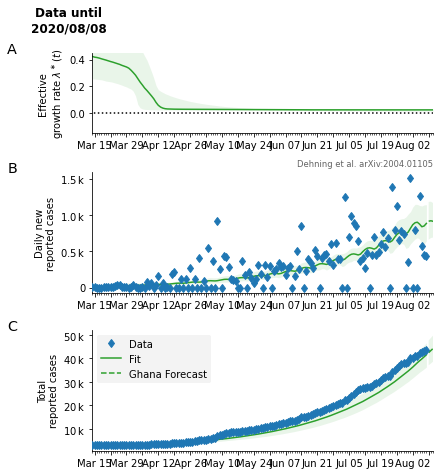

In [ ]:
plot_timeseries(model3, model3_trace, file_name="model3_timeseries.png")

Plot TImeseries for Validation data to compare

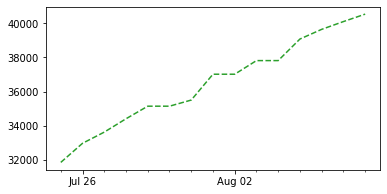

In [ ]:
plot_simpleTimeSeries(data=val_set, save_as='valset.png', type_of_plot='fcast');

### Model 3 Performance 

> The model's perfromance ....

## Predict model parameters (spread rate, recovery rate, etc. till August 10)

> Reset parameters to predict model up till August 10

In [ ]:
diff_data_sim = 10  # should be significantly larger than the expected delay, in order to always fit the same number of data points.
num_days_forecast = 10 #days

> Rebuild Model

In [ ]:
model3 = create_model(params_model,#sim_begin=datetime.datetime(2020,3,4), #sim_end=datetime.datetime(2020,8,4), 
             change_points=model3_change_points)

In [ ]:
#save model 3
save_load_model("wb", model3, "model3.pickle")
#load model 3
model3 = save_load_model("rb", model_name="model3.pickle")

In [ ]:
model3_trace =  pm.sample(model=model3, cores=4, tune=200, draws=500, init="advi+adapt_diag")

In [ ]:
#save model3_trace
save_load_modelTrace("wb", model3_trace, modelTrace_name="model3_trace.pickle")
#load model3_trace
model3_trace=save_load_modelTrace("rb", modelTrace_name="model3_trace.pickle")

In [ ]:
plot_timeseries(model3, model3_trace, file_name="model3_timeseries.png")

   ` `


## Plotting  Distributions

> Since we have a working model now, we can plot our model parameters such as:
- Lambda (spread rate)
- mu (recovery rate), etc.

### Analytical Summary

> We started by identifying the date the first covid case was recorded in Ghana. This was on March 14. We used this data to query the JHU database and identified March 26 as when the number of cases reached 100. We decided to use the date as the starting point of our analysis and the train data for our model and used July 25th as the end date for the trained model. This helped us to validate the accuracy of our analysis and forecast. We compared the prediction of the train data until August 2nd and found that the predictions were quite reliable and we then extended the model to predict up till August 10. The predicted number of cases for August 10 was between 500 t0 650 (0.50k - 0.65k) cases. 

> We identified some significant changepoints in our Time Series graph during the following dates:
- April 12 - A decrease in spread rate
- June 17 - A slow spread rate
- August 02 - A slow rise in spread rate.

> We checked to confirm if there were policies made around this period (factoring the delay time of 3 days). Our research on Ghana government policy interventions during this period confirmed that these changepoints could have been as a result of the following intervention policies made by the government
March 30, 2020 - Partial Lockdown by the Government
June 15, 2020 - Compulsory use of Facemasks
July 26,  2020 - Easing of Lockdown. 
The effects of these interventions were observed in the changepoints identified above. 
Our prediction till August 10 of an increase in spread rate would be validated in the future date from new cases reports from the Johns Hopkins Database


### Recoomendations and Conclusions

> From our analysis, we discovered that despite there were intervention policies by the government, timeliness of the interventions mattered most. Interventions’ effects do not occur until sometime later in the future. Hence in future pandemics, drastic and bold policies should be taken as early as possible giving little or no room for exponential growth in the rate of spread. 
As much as possible, delay in identification, testing and reporting of confirmed epidemic cases should  be shortened. This would help analysts get  a more accurate and timely forecast of future trends of the spread of the epidemic.


### Limitations
> The Analysis was based on data obtained from the Johns Hopkins University Database, hence the accuracy of the data, largely affects the accuracy of my analysis.
This analysis might not be so useful in future dates because some of the priors are based on available realities now which might change in the future. However, the qualitative significance of the work can be relied upon in tackling future epidemics.